In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd

# Path to the folder containing CSV files
folder_path = "/content/sample_data/csv"

# Check if the folder exists
if os.path.exists(folder_path):
    # List to hold all dataframes
    dfs = []

    # Iterate over each file in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            # Read each CSV file and append its dataframe to the list
            df = pd.read_csv(os.path.join(folder_path, file_name))
            dfs.append(df)

    # Check if any CSV files were found
    if len(dfs) > 0:
        # Concatenate all dataframes into one
        combined_df = pd.concat(dfs, ignore_index=True)




In [3]:
combined_df

,Unnamed: 0,Artist,Title,Album,Year,Date,Lyric
0,0.0,Katy Perry,Swish Swish,Witness,2017.0,2017-05-19,refrain they know what is what but they don't ...
1,1.0,Katy Perry,Chained to the Rhythm,Witness,2017.0,2017-02-10,katy perry are we crazy living our lives throu...
2,2.0,Katy Perry,Dark Horse,PRISM,2013.0,2013-10-18,juicy j yeah ya'll know what it is katy perry ...
3,3.0,Katy Perry,Bon Appétit,Witness,2017.0,2017-04-28,quavo ayy yeah katy perry migos ayy katy per...
4,4.0,Katy Perry,Roar,PRISM,2013.0,2013-08-10,i used to bite my tongue and hold my breath sc...
...,...,...,...,...,...,...,...
6022,516.0,Eminem,It’s the real slim shady,NaN,NaN,NaN,may i have your attention please may i have yo...
6023,517.0,Eminem,Kill Em’ All,NaN,NaN,NaN,lyrics for this song have yet to be released p...
6024,518.0,Eminem,Holy fucking shit..... *Punches drywall*,NaN,1999.0,1999-03-08,you couldn't impress me if you were elvis pres...
6025,519.0,Eminem,Premonition (Intro) (Kurdish Subtitle),NaN,2020.0,2020-01-17,ئینتڕۆ ئێمینێم هەڵیبێنم ئەمە چیە ها وابزانم ڕو...


In [4]:
df_new = combined_df[['Artist', 'Title', 'Lyric']].copy()

In [5]:
df_new["Lyric"][12]

"yeah i'm thankful scratch that baby i'm grateful gotta say it's really been a while but now i\u2005got\u2005back that smile\u2005smile i'm so thankful scratch that baby i'm\u2005grateful now you see me shine from a mile finally got back that smile smile   every day groundhog day goin' through motions felt so fake not myself not my best felt like i failed the test  pre but every tear has been a lesson rejection can be god's protection long hard road to get that redemption but no shortcuts to a blessin'   yeah i'm thankful scratch that baby i'm grateful gotta say it's really been a while but now i got back that smile smile i'm so thankful scratch that baby i'm grateful now you see me shine from a mile finally got back that smile smile   i'm 0 remodeled used to be dull now i sparkle had a piece of humble pie that ego check saved my life  pre now i got a smile like lionel richie big and bright need shades just to see me tryna stay alive just like i'm the bee gees oh woah a mona lisa maste

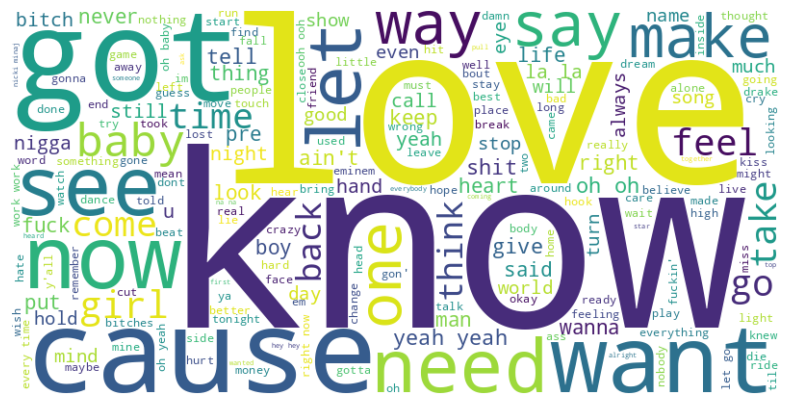

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Concatenate lyrics from DataFrame column into a single text string
lyrics_text = ' '.join(str(lyrics) for lyrics in df_new['Lyric'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(lyrics_text)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [9]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models import Word2Vec

song_df = df_new
song_df = song_df[(song_df["Lyric"].str.len() <= 3500) & (song_df["Lyric"].str.len() >= 400)]

# Remove duplicates
song_df.drop_duplicates(subset=["Artist", "Title"], inplace=True)

# Train Word2Vec model
# Ensure lyrics are treated as strings
lyrics_corpus = [str(lyric).split() for lyric in song_df['Lyric']]  # Convert lyrics to strings before splitting
word2vec_model = Word2Vec(sentences=lyrics_corpus, vector_size=100, window=5, min_count=1, workers=4)

def get_recommendations(input_lyrics, song_dataframe, word2vec_model):
    input_lyrics_tokens = input_lyrics.split()
    input_lyrics_vectors = [word2vec_model.wv[word] for word in input_lyrics_tokens if word in word2vec_model.wv.key_to_index]
    input_lyrics_vector = sum(input_lyrics_vectors) / len(input_lyrics_vectors) if input_lyrics_vectors else None

    similarities = []
    for idx, row in song_dataframe.iterrows():
        # Ensure song lyrics are treated as strings
        song_lyrics_tokens = str(row['Lyric']).split()  # Convert lyrics to strings before splitting
        song_lyrics_vectors = [word2vec_model.wv[word] for word in song_lyrics_tokens if word in word2vec_model.wv.key_to_index]
        song_lyrics_vector = sum(song_lyrics_vectors) / len(song_lyrics_vectors) if song_lyrics_vectors else None

        if input_lyrics_vector is not None and song_lyrics_vector is not None:
            similarity = word2vec_model.wv.cosine_similarities(input_lyrics_vector, [song_lyrics_vector])[0]
            similarities.append(similarity)
        else:
            similarities.append(0)  # Assign 0 similarity if one of the vectors is None

    song_dataframe['Similarity'] = similarities
    recommended_songs = song_dataframe.sort_values(by='Similarity', ascending=False).head(5)

    return recommended_songs[['Artist', 'Title', 'Similarity']]

# Example Usage
input_songs = "they wishin' and wishin"
recommended_songs = get_recommendations(input_songs, df_new, word2vec_model)
print(recommended_songs)

<ipython-input-9-fc4d830549d2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_df.drop_duplicates(subset=["Artist", "Title"], inplace=True)


             Artist                Title  Similarity
5187    Nicki Minaj  Talking that  stuff    0.834344
461     Post Malone     Never Understand    0.819513
2918          Drake    God’s Plan (Demo)    0.808707
927   Billie Eilish      Fingers Crossed    0.808628
186      Katy Perry   Daisies (MK Remix)    0.801767


In [11]:
# Import necessary libraries
import nltk
#nltk.download('stopwords')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import string

# Load the dataset and perform initial filtering
song_df = df_new
song_df = song_df[(song_df["Lyric"].str.len() <= 3500) & (song_df["Lyric"].str.len() >= 400)]

# Remove duplicates
song_df.drop_duplicates(subset=["Artist", "Title"], inplace=True)

## Remove stop words and clean lyrics
stop_words = set(stopwords.words('english'))

# Custom stopwords specific to song lyrics
custom_stop_words = {
    'oh', 'ah', 'yeah', 'baby', 'na', 'la', 'da', 'woo', 'hey',
    'gonna', 'wanna', 'gotta', 'ain', 'em', 'gon', 'wan', 'gimme',
    'im', 'ive', 'youre', 'dont', 'cant', 'wont', 'isnt', 'wasnt', 'hes', 'shes',
    'couldnt', 'wouldnt', 'shouldnt', 'aint', 'gimme', 'gimme', 'gotcha', 'gon', 'wanna',
    'gotta', 'aint', 'imma', 'imma', 'imma', 'ima', 'imma', 'uh', 'uhh', 'uhhh', 'mmm',
    'mmmh', 'hmm', 'hmmh', 'mmmm', 'mmmmh', 'na', 'nah', 'yeah', 'yeh', 'yay', 'uhuh',
    'uh-uh', 'uhhuh', 'oh', 'ooh', 'oohh', 'ah', 'ahh', 'ahhh', 'huh', 'huhh', 'huhhh',
    'hey', 'heyy', 'heyyy', 'oh', 'ah', 'woah', 'whoa', 'la', 'lala', 'lalala', 'lalala',
    'da', 'dadada', 'dada', 'dadaa', 'dadaaa', 'dum', 'dumdum', 'dummm', 'dummm', 'dummmm'
}

# Combine NLTK stopwords and custom stopwords
all_stop_words = stop_words.union(custom_stop_words)

punctuation = set(string.punctuation)

def clean_lyrics(lyric):
    # Convert text to lowercase
    lyric = lyric.lower()
    # Remove punctuation
    lyric = ''.join(char for char in lyric if char not in punctuation)
    # Remove stopwords
    lyric = ' '.join(word for word in lyric.split() if word not in all_stop_words)
    return lyric

song_df['Cleaned_Lyric'] = song_df['Lyric'].apply(clean_lyrics)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-11-749e2c39a418>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_df.drop_duplicates(subset=["Artist", "Title"], inplace=True)
<ipython-input-11-749e2c39a418>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_df['Cleaned_Lyric'] = song_df['Lyric'].apply(clean_lyrics)


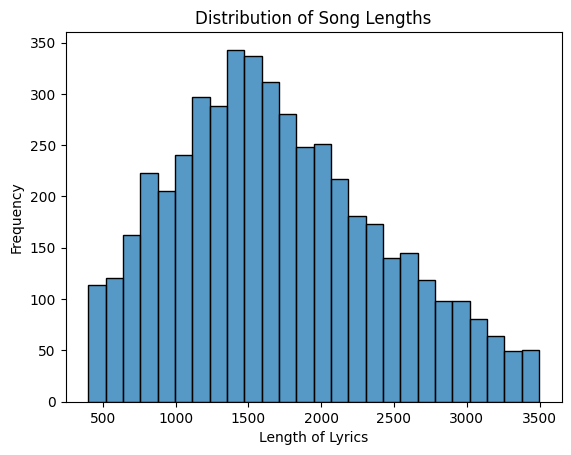

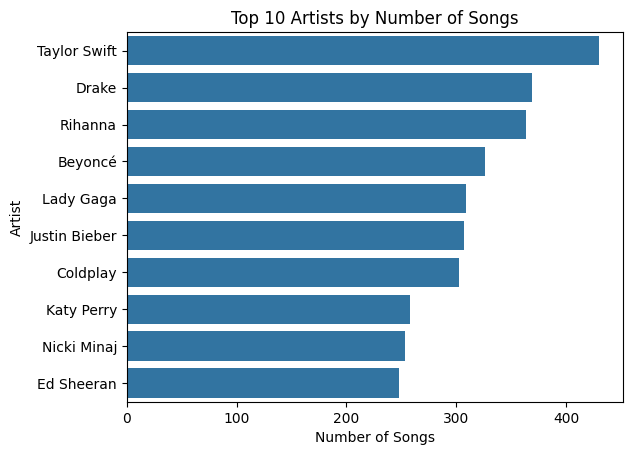

In [12]:
# Exploratory Data Analysis (EDA)
# Visualize the distribution of song lengths
sns.histplot(song_df['Lyric'].str.len())
plt.xlabel('Length of Lyrics')
plt.ylabel('Frequency')
plt.title('Distribution of Song Lengths')
plt.show()

# Visualize the distribution of artists
sns.countplot(y='Artist', data=song_df, order=song_df['Artist'].value_counts().index[:10])
plt.xlabel('Number of Songs')
plt.ylabel('Artist')
plt.title('Top 10 Artists by Number of Songs')
plt.show()

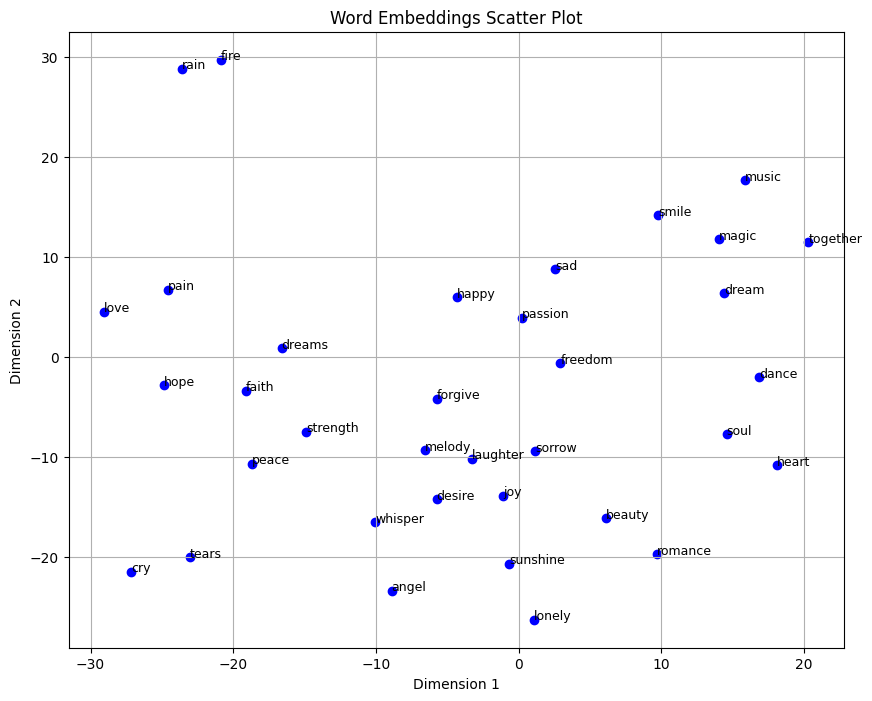

In [13]:
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

words_of_interest = ['love', 'music', 'happy', 'sad', 'dance', 'heart', 'joy', 'cry', 'smile', 'passion',
                     'melody', 'sorrow', 'romance', 'hope', 'dream', 'peace', 'pain', 'soul', 'desire',
                     'together', 'lonely', 'forgive', 'faith', 'magic', 'sunshine', 'rain', 'angel',
                     'fire', 'dreams', 'whisper', 'laughter', 'tears', 'strength', 'beauty', 'freedom']  # Choose words from your dataset
word_embeddings = [word2vec_model.wv[word] for word in words_of_interest]
word_embeddings = np.array(word_embeddings)
# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, perplexity=4, random_state=42)  # Adjust perplexity as needed
word_embeddings_2d = tsne.fit_transform(word_embeddings)


# Plot the scatter plot
plt.figure(figsize=(10, 8))
for i, word in enumerate(words_of_interest):
    plt.scatter(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1], marker='o', color='blue')
    plt.text(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1], word, fontsize=9)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Embeddings Scatter Plot')
plt.grid(True)
plt.show()

In [14]:
# Train Word2Vec model
lyrics_corpus = [lyric.split() for lyric in song_df['Cleaned_Lyric']]
word2vec_model = Word2Vec(sentences=lyrics_corpus, vector_size=100, window=5, min_count=1, workers=4)

In [15]:
def get_recommendations(input_lyrics, song_dataframe, word2vec_model):
    input_lyrics_tokens = input_lyrics.split()
    input_lyrics_vector = sum([word2vec_model.wv[word] for word in input_lyrics_tokens if word in word2vec_model.wv.key_to_index]) / len(input_lyrics_tokens)

    similarities = []
    for idx, row in song_dataframe.iterrows():
        if isinstance(row['Lyric'], str):  # Check if 'Lyric' is a string
            song_lyrics_tokens = row['Lyric'].split()
            song_lyrics_vectors = [word2vec_model.wv[word] for word in song_lyrics_tokens if word in word2vec_model.wv.key_to_index]
            song_lyrics_vector = sum(song_lyrics_vectors) / len(song_lyrics_vectors) if song_lyrics_vectors else None
            if song_lyrics_vector is not None:
                similarity = np.dot(input_lyrics_vector, song_lyrics_vector) / (np.linalg.norm(input_lyrics_vector) * np.linalg.norm(song_lyrics_vector))
                similarities.append((row['Title'], similarity))
        else:
            # Convert non-string values to strings before proceeding
            lyric_str = str(row['Lyric'])
            song_lyrics_tokens = lyric_str.split()
            song_lyrics_vectors = [word2vec_model.wv[word] for word in song_lyrics_tokens if word in word2vec_model.wv.key_to_index]
            song_lyrics_vector = sum(song_lyrics_vectors) / len(song_lyrics_vectors) if song_lyrics_vectors else None
            if song_lyrics_vector is not None:
                similarity = np.dot(input_lyrics_vector, song_lyrics_vector) / (np.linalg.norm(input_lyrics_vector) * np.linalg.norm(song_lyrics_vector))
                similarities.append((row['Title'], similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities


In [16]:
# Example Usage
input_songs = "night changes"
recommended_songs = get_recommendations(input_songs, df_new, word2vec_model)
print(recommended_songs)

[('Goodnight Gotham', 0.9899552), ('Marry the Night (Zedd Remix)', 0.95920336), ('Marry the Night - The Weeknd & Illangelo Remix', 0.9491944), ('Marry the Night', 0.94575495), ('My Life', 0.91820854), ('Last Friday Night (T.G.I.F.)', 0.91502964), ('Spoil My Night', 0.90704995), ('Last Friday Night (T.G.I.F.) [Remix]', 0.89771897), ('Silent Night', 0.88717765), ('Earth to Move', 0.8809141), ('Silent Night', 0.8795993), ('Lost In Your Light', 0.86546046), ('Spend The Night', 0.8616091), ('Give Me That', 0.85751194), ('America', 0.85202515), ('Cece’s Interlude', 0.84685904), ('Cemeteries of London', 0.84563863), ('Save the Day', 0.84082794), ('Everynight', 0.8371583), ('Frankensteined (Fanmade Edit)', 0.8305234), ('Up All Night', 0.8289949), ('25/8', 0.82736754), ('Eleven (Remix)', 0.82657087), ('Levitating (KUU Remix)', 0.8233234), ('One Night Only (Disco)', 0.8229909), ('THE STARS', 0.8212024), ('My My My (Deezer Sessions)', 0.820658), ('Gaze', 0.8199294), ('All Night Long', 0.8188167),

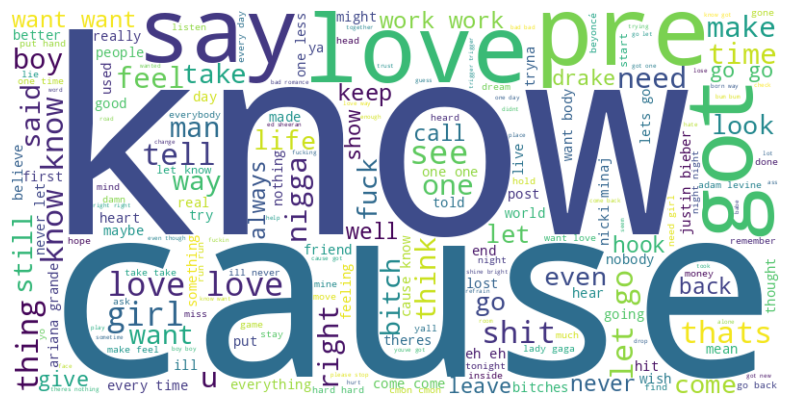

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Concatenate lyrics from DataFrame column into a single text string
lyrics_text = ' '.join(str(lyrics) for lyrics in song_df['Cleaned_Lyric'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(lyrics_text)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
